# This plotting script is used to visualize outputs from the ```lai_model_calibrate``` routine

In [74]:
%Load the inputs
workingDir = 'F:\Users\Anthony\Modeling\ILHM\Prep\2014\LP_Model\Import_Working';
inFilename = 'lai_model_calibrate.mat';
inFile = [workingDir,filesep,inFilename];
load(inFile,'modelParams');

%Specify outputs
outGraphicsDir = 'S:\Users\kendal30\Documents\Graphics\2018\9_30_2018_LAI_Modeling';
outTableDir = 'S:\Users\kendal30\Project_Files\2018\LAI_Modeling_for_EBCW';

%Define some common inputs for the rest of the plots
luTypes = fieldnames(modelParams);
numLU = length(luTypes);
colors = [255,0,0;217,200,25;15,177,32;70,127,50;49,183,214;120,120,120;0,0,0;227,114,59;44,186,124]/256;

%Specify some plotting stuff
plotCols = 3;
plotRows = ceil(numLU/plotCols);
imatlab_export_fig('print-png')  % Static png figures.

%Addpaths to LHM frontend
cd('S:\Users\kendal30\Code\lhm\frontend')
addpath_frontend

## Convert the structure to a table, export it


In [105]:
paramsTable = table('Size',[numLU,9],...
'VariableTypes',{'string','double','double','double','double','double','double','double','double'},...
'VariableNames',{'Land_Use','gddMature','riseExp','riseSlope','fallExp','fallSlope','T_GDD','T_SDD','ppFactor'});
for m = 1:numLU
    paramsTable(m,1) = luTypes(m);
    for n = 1:8
        paramsTable(m,n+1) = {modelParams.(luTypes{m}).params(n)};
    end
end
paramsTable
writetable(paramsTable,[outTableDir,filesep,'lai_model_params.csv'])


paramsTable =

  9x9 table

       Land_Use        gddMature     riseExp      riseSlope     fallExp     fallSlope     T_GDD     T_SDD     ppFactor
    _______________    _________    __________    _________    _________    _________    _______    ______    ________

    "urban"             1070.8       0.0014337     943.93      0.0047753     889.97      -2.2803    20.147    0.51449 
    "agriculture"       1043.1       0.0011865       1014      0.0063344     1175.5      -1.9052    20.101     0.5435 
    "grassland"         1139.9       0.0010718     1310.9      0.0046877     825.03      -1.8787    20.866    0.54739 
    "deciduous"         807.02        0.004477     695.77      0.0077407     594.21       4.5816    20.914    0.55753 
    "wetland"           1093.2       0.0010508     1076.5      0.0053283     986.71      -1.7642     21.24    0.53216 
    "barren"            1087.7       0.0012467       1014      0.0037422     1062.3      -1.5191    21.554    0.52863 
    "coniferous"  

## Plot simulated vs. observed LAI values as a splom
Also, this will fit lines to each and display the R2 and slope on the graphic as text

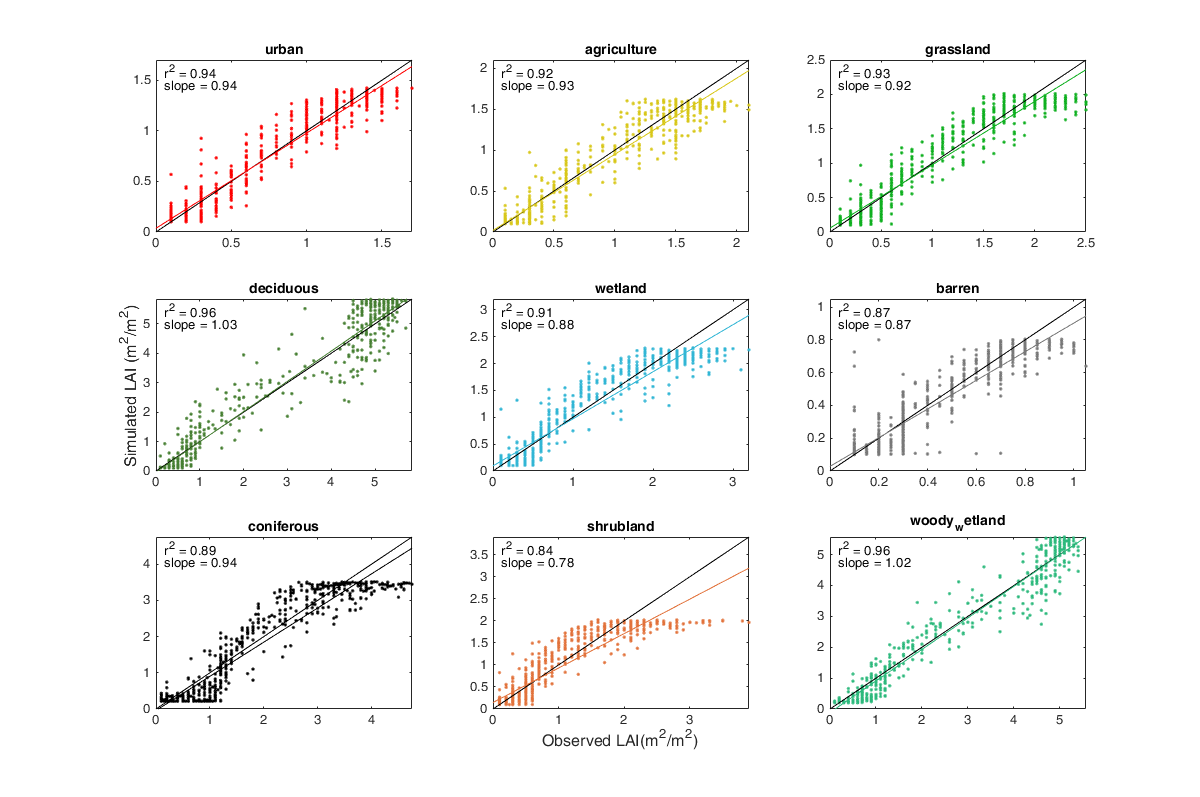

In [81]:
f1 = figure('Position',[0,0,1200,1200]);
for m = 1:numLU
    luType = luTypes{m};
    subplot(plotCols,plotRows,m)
    
    %Calculate laiCalib to match the lai data
    indNan = isnan(modelParams.(luType).laiAvg);
    obsLai = modelParams.(luType).laiAvg(~indNan);
    obsTime = modelParams.(luType).laiTime(~indNan);
    simLai = interp1(modelParams.(luType).modDays,modelParams.(luType).modLaiAvg,obsTime,'linear','extrap');
        
    %Fit a line to the data, and calculate r2
    p = polyfit(obsLai,simLai,1);
    r = corrcoef(obsLai,simLai);
    r2 = r(2)^2;
    
    %Make the plots
    plot(obsLai,simLai,'.','color',colors(m,:))
    hold on
    plotRange = [0,max([obsLai;simLai(:)])];
    plot(plotRange,plotRange,'k-')
    plot(plotRange,polyval(p,plotRange),'-','color',colors(m,:));
    hold off
    
    %Add text for slope and r2
    text(plotRange(1)+diff(plotRange)/100*3,plotRange(2)-diff(plotRange)/100*7,sprintf('r^2 = %0.2f',r2));
    text(plotRange(1)+diff(plotRange)/100*3,plotRange(2)-diff(plotRange)/100*15,sprintf('slope = %3.2f',p(1)));
    
    %Decorate the plot
    title(luType);
    set(gca,'XLim',plotRange);
    set(gca,'YLim',plotRange);
    if m == 4
        ylabel('Simulated LAI (m^2/m^2)','Fontsize',12)
    end
    if m == 8
        xlabel('Observed LAI(m^2/m^2)','Fontsize',12)
    end
end

%Save this to file
print(f1,[outGraphicsDir,filesep,'simvobs.svg'],'-dsvg')

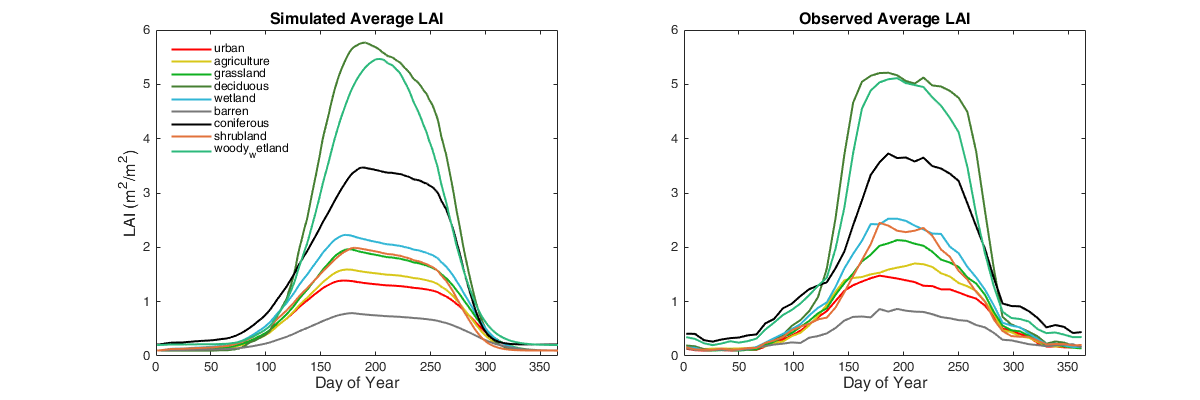

In [80]:
f2 = figure('Position',[0,0,1200,400]);
subplot(1,2,1);
hold on;
box on;
for m = 1:numLU
    luType = luTypes{m};
    [doy,laiPlot] = time_series_aggregate(modelParams.(luType).modDays,modelParams.(luType).modLaiAvg,...
        'days','mean','years','mean');
    plot(doy,laiPlot,'color',colors(m,:),'LineWidth',1.5)
end
%legend(luTypes)
xlabel('Day of Year','Fontsize',12)
set(gca,'XLim',[0,366]);
ylabel('LAI (m^2/m^2)','Fontsize',12)
title('Simulated Average LAI','Fontsize',12)
legend(luTypes,'Location','northwest')
legend('boxoff')
hold off;

subplot(1,2,2);
hold on;
box on;
luTypes = fieldnames(modelParams);
for m = 1:length(luTypes)
    luType = luTypes{m};
    [doy,laiPlot] = time_series_aggregate(modelParams.(luType).laiTime,modelParams.(luType).laiAvg,...
        'days','mean','years','mean');
    plot(doy,laiPlot,'color',colors(m,:),'LineWidth',1.5)
end

xlabel('Day of Year','Fontsize',12)
set(gca,'XLim',[0,366]);
title('Observed Average LAI','Fontsize',12)
hold off;

%Save this to file
print(f2,[outGraphicsDir,filesep,'doy_LAI_comparison.svg'],'-dsvg')

## Plot time-varying simulated and observed values
This shows the time-varying nature of the LAI model versus the observations.

In [ ]:
%This is for plotting outputs
figure;
for m = 1:numLU
    luType = luTypes{m};
    subplot(plotCols,plotRows,m)
    hold on
    box on
    plot(modelParams.(luType).laiTime,modelParams.(luType).laiAvg,'k-');
    plot(modelParams.(luType).modDays,modelParams.(luType).modLaiAvg,'color',colors(m,:));
    datetick('mm-dd-yyyy')
    hold off
    title(luType);
end